# Experiment - weight transfering

Import statements:

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(43)

## 1. Weather dataset

### 1.1. Import

In [89]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [90]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [91]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here's the evolution of a few features over time:

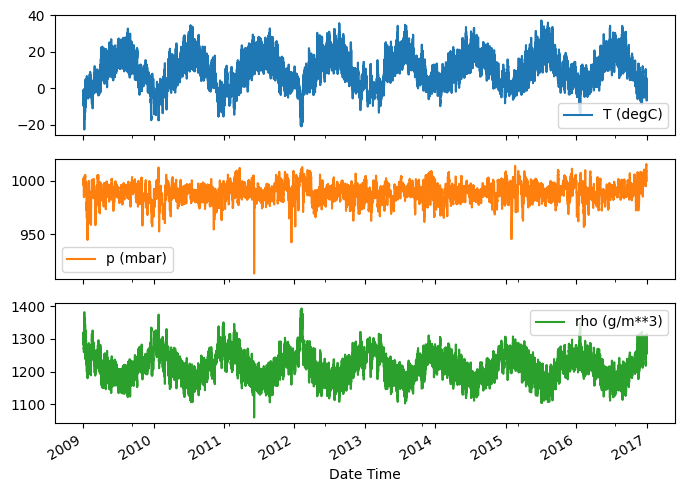

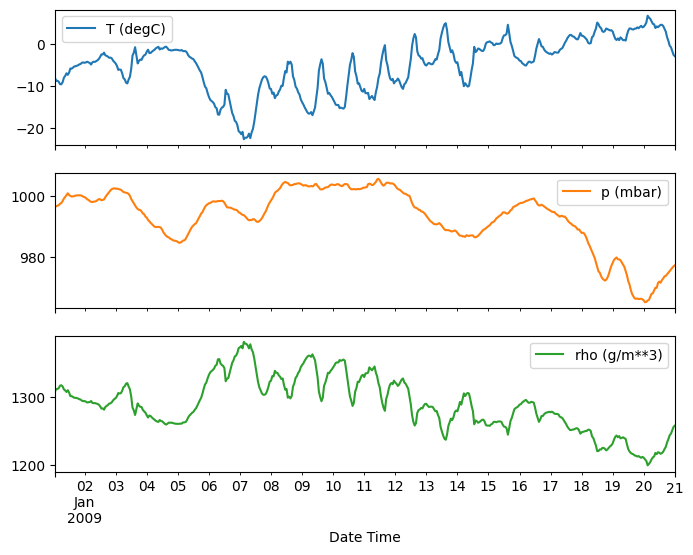

In [92]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 1.2. Inspeact and cleanup


Next, look at the statistics of the dataset:

In [93]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### 1.3. Wind velocity

One thing that should stand out is the min value of the wind velocity (wv (m/s)) and the maximum value (max. wv (m/s)) columns. This -9999 is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (>=0). Replace it with zeros:

In [94]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### 1.4. Feature Engineering


Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

##### Wind

The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

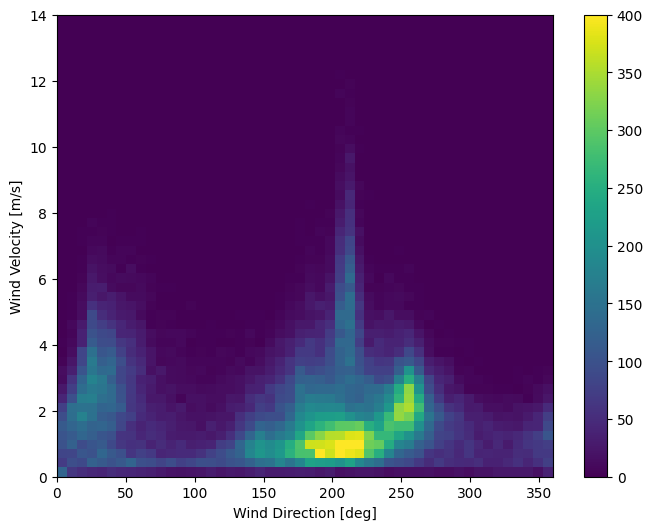

In [95]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [96]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

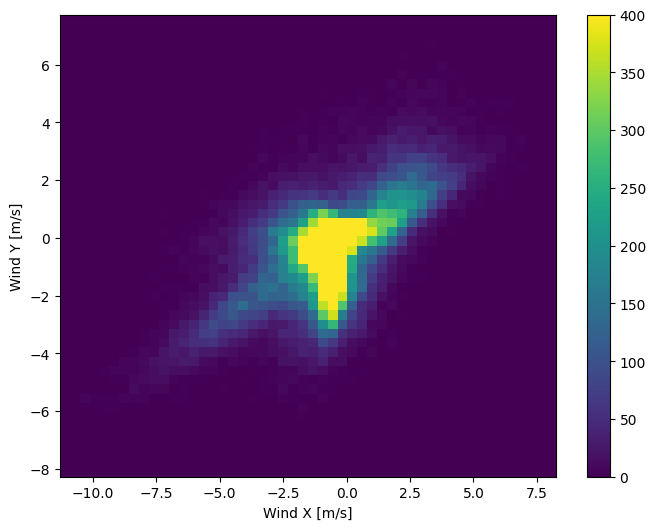

In [97]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

##### Time 

**Similarly**, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [98]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [99]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

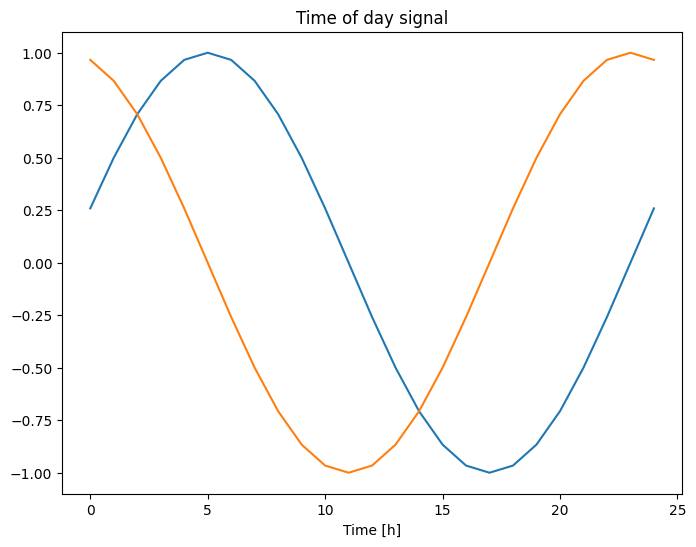

In [100]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


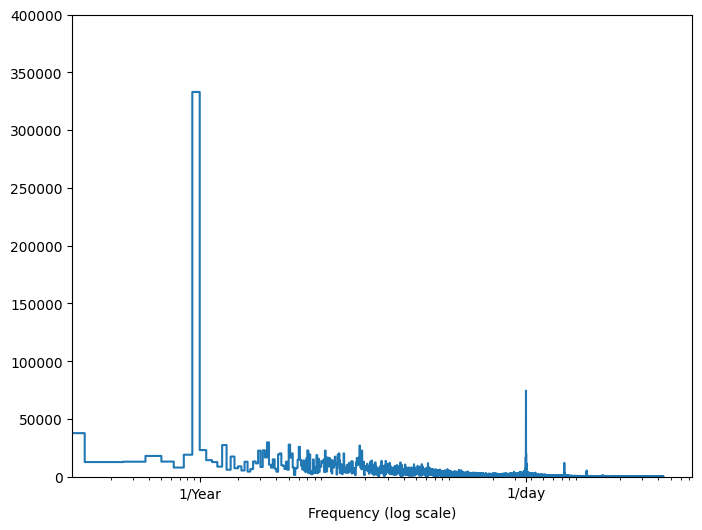

In [101]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 1.5. Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [102]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_column = train_df['T (degC)'].copy()
val_column = val_df['T (degC)'].copy()
test_column = test_df['T (degC)'].copy()

num_features = df.shape[1]

### 1.6. Normalize the Data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [103]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df['T (degC)'] = train_column
val_df['T (degC)'] = val_column
test_df['T (degC)'] = test_column


Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

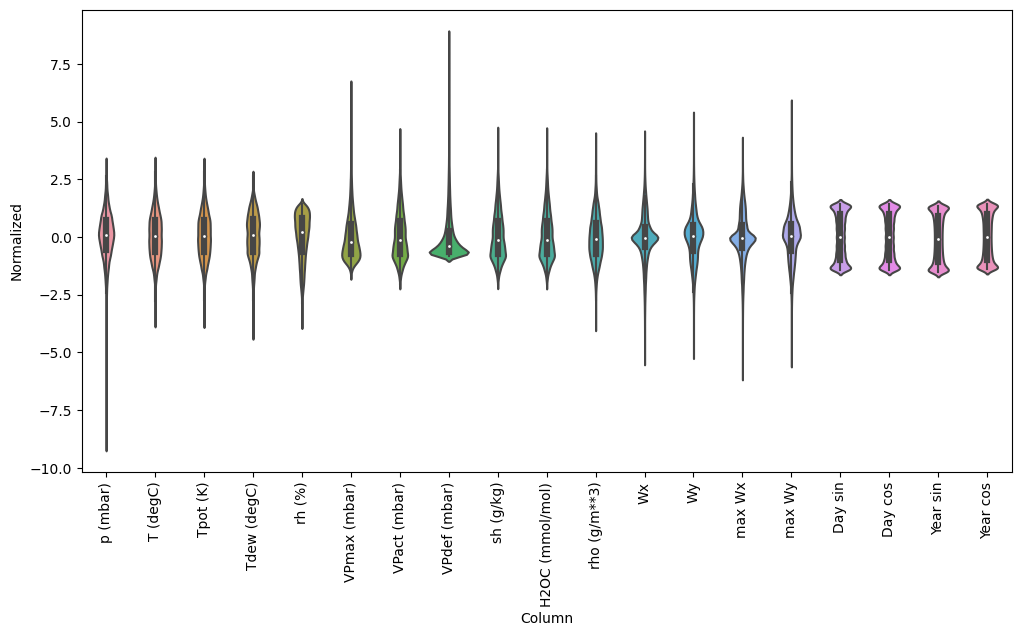

In [104]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [105]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-8.05,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-8.88,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-8.81,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-9.05,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-9.63,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388


## 2. Data Windowing

### 2.1. Indexes and offsets
Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.

In [106]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df, batch_size=32,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size=batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=self.batch_size,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    def __repr__(self):
      return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

## 3. Models

Create dataset for window sequences:

In [208]:
wide_window = WindowGenerator(
    input_width=23, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=0,
    label_columns=['T (degC)'])


test_single_window = WindowGenerator(
    input_width=1, label_width=1, shift=0,
    label_columns=['T (degC)'], batch_size=1)
test_wide_window = WindowGenerator(
    input_width=24, label_width=1, shift=0,
    label_columns=['T (degC)'], batch_size=1)


for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Wide window inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Wide window labels shape (batch, time, features): {example_labels.shape}')


for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Single step inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Single step labels shape (batch, time, features): {example_labels.shape}')


Wide window inputs shape (batch, time, features): (32, 23, 19)
Wide window labels shape (batch, time, features): (32, 1, 1)
Single step inputs shape (batch, time, features): (32, 1, 19)
Single step labels shape (batch, time, features): (32, 1, 1)


Create recurrent model:

In [209]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, stateful=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [210]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)
print(lstm_model(wide_window.example[0]).shape)

Input shape: (32, 23, 19)
Output shape: (32, 1)
(32, 1)


Train model:

In [211]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [212]:
val_performance = {}
performance = {}

In [213]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
1533/1533 [==============================] - 9s 5ms/step - loss: 15.7437 - mean_absolute_error: 2.2808 - val_loss: 2.5816 - val_mean_absolute_error: 0.8293
Epoch 2/20
1533/1533 [==============================] - 7s 5ms/step - loss: 1.4409 - mean_absolute_error: 0.6827 - val_loss: 1.0764 - val_mean_absolute_error: 0.6234
Epoch 3/20
1533/1533 [==============================] - 7s 5ms/step - loss: 0.7191 - mean_absolute_error: 0.5484 - val_loss: 0.7049 - val_mean_absolute_error: 0.5404
Epoch 4/20
1533/1533 [==============================] - 7s 5ms/step - loss: 0.5634 - mean_absolute_error: 0.5111 - val_loss: 0.5741 - val_mean_absolute_error: 0.5090
Epoch 5/20
1533/1533 [==============================] - 7s 5ms/step - loss: 0.5058 - mean_absolute_error: 0.4914 - val_loss: 0.5504 - val_mean_absolute_error: 0.5154
Epoch 6/20
1533/1533 [==============================] - 7s 5ms/step - loss: 0.4850 - mean_absolute_error: 0.4847 - val_loss: 0.4956 - val_mean_absolute_error: 0.4858
Epo

In [214]:
lstm_model.save_weights(
    'data', overwrite=True, save_format=None, options=None
)

In [215]:
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                6656      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


### Evaluate

#### Base model (sequence length 24)

Batch size 32:

In [216]:
val_performance['base_32'] = lstm_model.evaluate(wide_window.val)
performance['base_32'] = lstm_model.evaluate(wide_window.test)

219/219 [==============================] - 0s 1ms/step - loss: 0.4439 - mean_absolute_error: 0.4771


Batch size 1:

In [217]:
val_performance['base_1'] = lstm_model.evaluate(test_wide_window.val)
performance['base_1'] = lstm_model.evaluate(test_wide_window.test)

6987/6987 [==============================] - 9s 1ms/step - loss: 0.8726 - mean_absolute_error: 0.7308


#### LSTM model (sequence length 1)

Batch size 32:

In [218]:
val_performance['base_32'] = lstm_model.evaluate(single_step_window.val)
performance['base_32'] = lstm_model.evaluate(single_step_window.test)

220/220 [==============================] - 0s 687us/step - loss: 37.3826 - mean_absolute_error: 4.6218


Batch size 1:

In [219]:
val_performance['base_32'] = lstm_model.evaluate(test_single_window.val)
performance['base_32'] = lstm_model.evaluate(test_single_window.test)

7010/7010 [==============================] - 4s 518us/step - loss: 37.3826 - mean_absolute_error: 4.6219


transfered models:

In [220]:
new_model =  tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, stateful=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
new_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [221]:
example_out = new_model(tf.ones((1, 1, 19)))

In [222]:
new_model.set_weights(lstm_model.get_weights())


In [223]:
new_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (1, 32)                   6656      
                                                                 
 dense_12 (Dense)            (1, 1)                    33        
                                                                 
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [224]:
i = 1
for element in test_single_window.val.as_numpy_iterator():
   print(f'{i} -> {element[1]}')
   
   if i == 24:
      break
   i += 1

print("-------")
for element in test_wide_window.val.as_numpy_iterator():
   print(element[1])
   break


1 -> [[[14.46]]]
2 -> [[[13.83]]]
3 -> [[[13.53]]]
4 -> [[[13.33]]]
5 -> [[[13.46]]]
6 -> [[[13.69]]]
7 -> [[[14.24]]]
8 -> [[[16.58]]]
9 -> [[[17.57]]]
10 -> [[[19.23]]]
11 -> [[[20.19]]]
12 -> [[[20.86]]]
13 -> [[[22.03]]]
14 -> [[[22.52]]]
15 -> [[[19.9]]]
16 -> [[[19.88]]]
17 -> [[[20.1]]]
18 -> [[[18.62]]]
19 -> [[[17.03]]]
20 -> [[[16.73]]]
21 -> [[[15.92]]]
22 -> [[[14.85]]]
23 -> [[[14.59]]]
24 -> [[[13.81]]]
-------
[[[13.81]]]


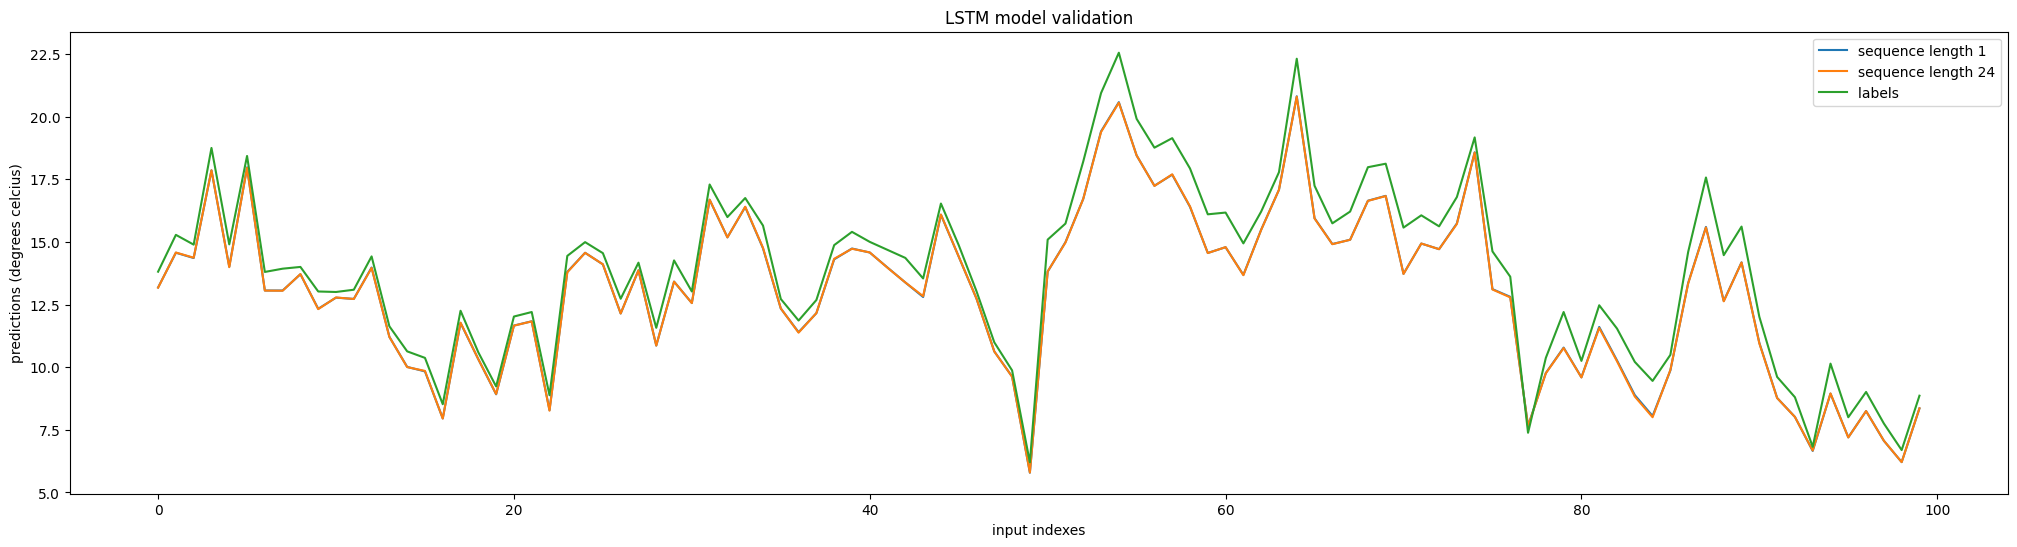

In [226]:
mpl.rcParams['figure.figsize'] = (25, 6)
mpl.rcParams['axes.grid'] = False


plt.title("LSTM model validation") 
plt.xlabel("input indexes") 
plt.ylabel("predictions (degrees celcius)") 

lstm = np.ndarray(shape=(0,))
new = np.ndarray(shape=(0,))
labels = np.ndarray(shape=(0,))
indexes = range(100)

i = 1
limit = 100 #num of sequences
seq = np.ndarray(shape=(1, 0, 19))
for element in test_single_window.val.as_numpy_iterator():
    seq = np.append(seq, element[0], axis=1)
 
    if seq.shape[1] == 24:
        lstm = np.append(lstm, lstm_model(seq))
        new = np.append(new, new_model(element[0]))
        labels = np.append(labels, element[1])
        seq = np.ndarray(shape=(1, 0, 19))    # reset sequence
    else:
        new_model(element[0])
    
    if i == limit * 24:
        break
    i += 1

plt.plot(indexes, new, label = "sequence length 1") 
plt.plot(indexes,lstm, label = "sequence length 24") 
plt.plot(indexes, labels, label = "labels ") 
plt.legend()
plt.show()

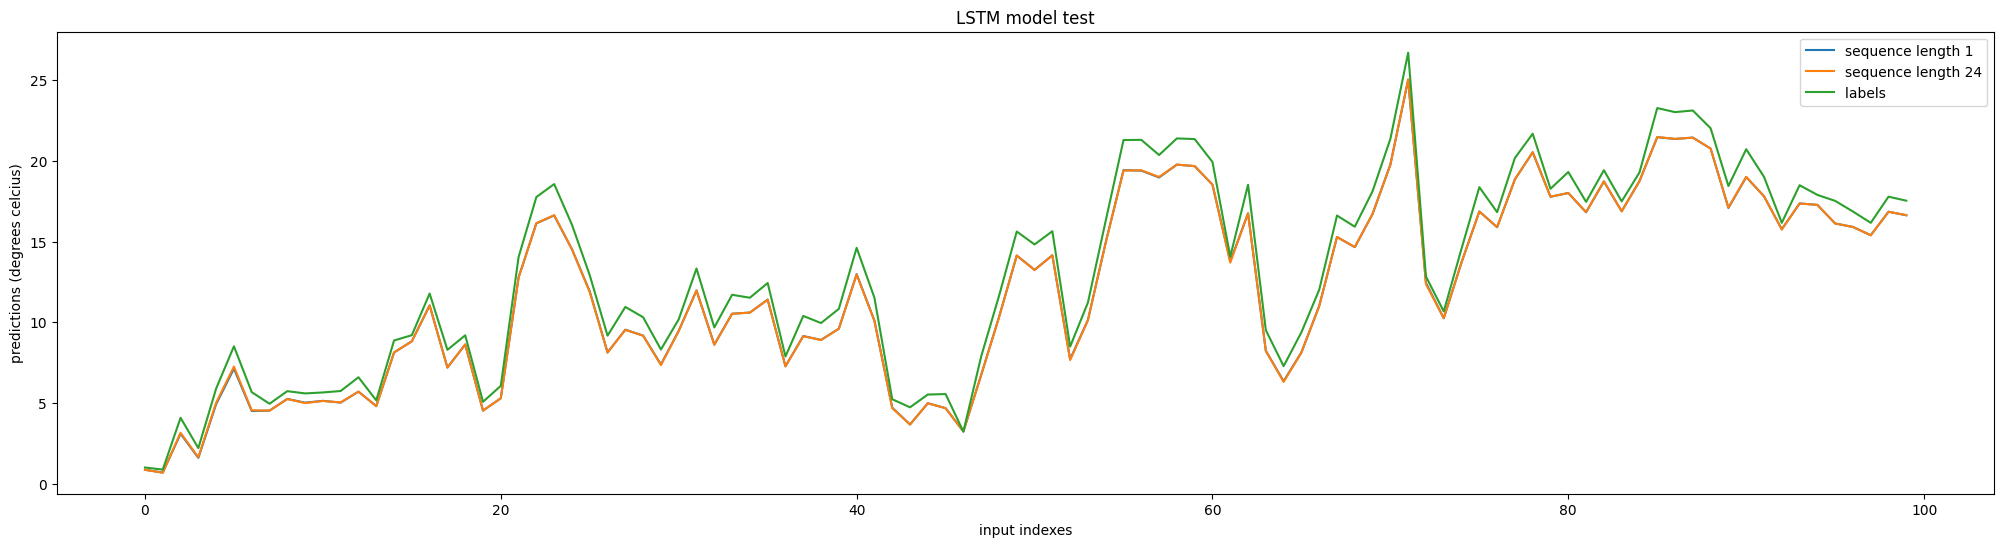

In [227]:
mpl.rcParams['figure.figsize'] = (25, 6)
mpl.rcParams['axes.grid'] = False


plt.title("LSTM model test") 
plt.xlabel("input indexes") 
plt.ylabel("predictions (degrees celcius)") 

lstm = np.ndarray(shape=(0,))
new = np.ndarray(shape=(0,))
labels = np.ndarray(shape=(0,))
indexes = range(100)

i = 1
limit = 100 #num of sequences
seq = np.ndarray(shape=(1, 0, 19))
for element in test_single_window.test.as_numpy_iterator():
    seq = np.append(seq, element[0], axis=1)
 
    if seq.shape[1] == 24:
        lstm = np.append(lstm, lstm_model(seq))
        new = np.append(new, new_model(element[0]))
        labels = np.append(labels, element[1])
        seq = np.ndarray(shape=(1, 0, 19))    # reset sequence
    else:
        new_model(element[0])
    
    if i == limit * 24:
        break
    i += 1

plt.plot(indexes, new, label = "sequence length 1") 
plt.plot(indexes,lstm, label = "sequence length 24") 
plt.plot(indexes, labels, label = "labels ") 
plt.legend()
plt.show()